In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))



In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

In [4]:
def analyze_and_forecast(file_path):
    data = pd.read_csv(file_path)
    data.columns = data.columns.str.strip()

    data.rename(columns={'Price': 'Date'}, inplace=True)
    
    # Convert date formats
    data['Date'] = pd.to_datetime(data['Date'], errors='coerce')
    data = data.dropna(subset=['Date'])
    data.set_index('Date', inplace=True)

    # Ensure numeric values
    numeric_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
    for col in numeric_columns:
        if col in data.columns:
            data[col] = pd.to_numeric(data[col], errors='coerce')

    # Drop rows with missing values
    data = data.dropna()

    # Exploratory Data Analysis
    print("\nDataset Info:")
    print(data.info())
    print("\nDataset Description:")
    print(data.describe())

    # Visualize closing price
    plt.figure(figsize=(12, 6))
    plt.plot(data.index, data['Close'], label='Close Price', color='blue')
    plt.title('Closing Price Over Time')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    # Correlation heatmap
    plt.figure(figsize=(10, 6))
    sns.heatmap(data.corr(), annot=True, cmap='coolwarm')
    plt.title('Correlation Heatmap')
    plt.show()

    # Decompose time series
    decomposition = seasonal_decompose(data['Close'], model='multiplicative', period=30)
    decomposition.plot()
    plt.show()

    # Stationarity test
    result = adfuller(data['Close'])
    print("\nADF Test Results:")
    print(f"ADF Statistic: {result[0]}")
    print(f"p-value: {result[1]}")
    if result[1] < 0.05:
        print("The time series is stationary.")
    else:
        print("The time series is not stationary.")

    # Prepare data for LSTM
    scaler = MinMaxScaler(feature_range=(0, 1))
    scaled_data = scaler.fit_transform(data[['Close']].values)

    sequence_length = 60
    X, y = [], []
    for i in range(sequence_length, len(scaled_data)):
        X.append(scaled_data[i-sequence_length:i])
        y.append(scaled_data[i, 0])

    X, y = np.array(X), np.array(y)

    # Split data
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Reshape for LSTM
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
    X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

    # Build LSTM model
    model = Sequential([
        LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)),
        Dropout(0.2),
        LSTM(units=50, return_sequences=False),
        Dropout(0.2),
        Dense(units=1)
    ])
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=20, batch_size=32, verbose=1)

    # Make predictions
    predictions = model.predict(X_test)
    predictions = scaler.inverse_transform(predictions)
    y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

    # Plot actual vs predicted
    test_dates = data.index[-len(y_test):]
    plt.figure(figsize=(12, 6))
    plt.plot(test_dates, y_test, label='Actual Price', color='blue')
    plt.plot(test_dates, predictions, label='Predicted Price', color='red')
    plt.title('Actual vs Predicted Prices')
    plt.xlabel('Date')
    plt.ylabel('Price')
    plt.legend()
    plt.show()

    print("Analysis and Forecasting Complete")


Dataset Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1697 entries, 2018-01-02 to 2024-09-30
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Adj Close  1697 non-null   float64
 1   Close      1697 non-null   float64
 2   High       1697 non-null   float64
 3   Low        1697 non-null   float64
 4   Open       1697 non-null   float64
 5   Volume     1697 non-null   int64  
dtypes: float64(5), int64(1)
memory usage: 92.8 KB
None

Dataset Description:
         Adj Close        Close         High          Low         Open  \
count  1697.000000  1697.000000  1697.000000  1697.000000  1697.000000   
mean     24.797593    24.828411    25.295239    24.315422    24.823341   
std      29.221442    29.216014    29.811740    28.570804    29.240504   
min       3.151430     3.177000     3.249500     3.111500     3.162250   
25%       6.113620     6.161750     6.250000     6.064250     6.166250   
50%      13.985092 

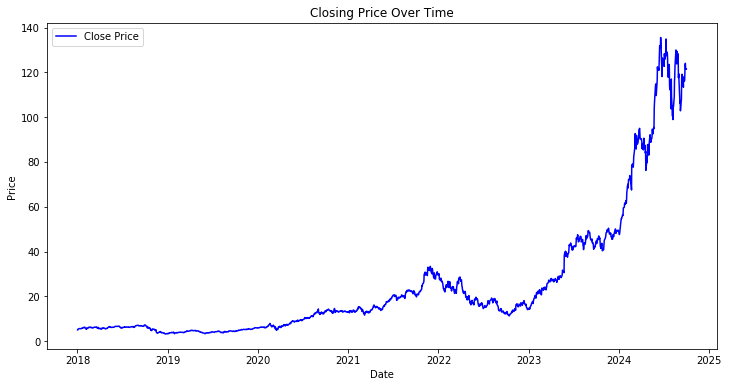

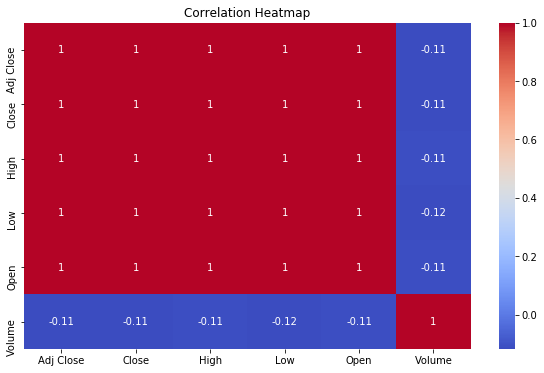

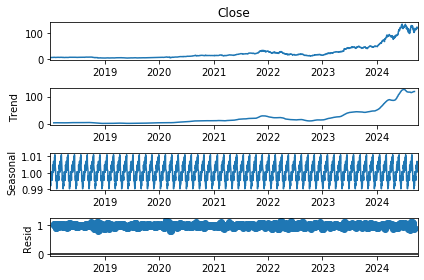


ADF Test Results:
ADF Statistic: 1.6381202033911477
p-value: 0.997967550949341
The time series is not stationary.


NotImplementedError: Cannot convert a symbolic Tensor (lstm/strided_slice:0) to a numpy array.

In [6]:
file_path = "NVIDIA_STOCK.csv"
analyze_and_forecast(file_path)